In [1]:
import captum
import torch
import thermostat
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients, FeatureAblation
from matplotlib import pyplot as plt
import json
from tqdm import tqdm

In [2]:
from datasets import load_dataset
dataset = load_dataset('imdb', ignore_verifications=True)

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /home/tim/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("textattack/distilbert-base-uncased-imdb")

model = AutoModelForSequenceClassification.from_pretrained("textattack/distilbert-base-uncased-imdb", return_dict=False)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/485 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [4]:
forward_func = lambda *x: model(*x)[0]

In [5]:
import onnxruntime as ort
ort_session = ort.InferenceSession("../models/distilbert-base-uncased-imdb/model-optimized-quantized.onnx")
callable_expr = lambda x: ort_session.run(["output_0"], dict(input_ids=np.array(x),
                                                        attention_mask=np.ones_like(x)))[0][0]

In [6]:
diffs = []
for data in tqdm(dataset["test"]):
    input1 = tokenizer(data["text"])
    input_ids = torch.tensor([input1["input_ids"]]).long()[:,:512]
    quant_result = callable_expr(input_ids)
    full_result = forward_func(input_ids)[0]
    diffs.append(float(sum(abs(torch.sigmoid(torch.tensor(quant_result))) - abs(torch.sigmoid(full_result)))))

mean_diff = np.mean(np.abs(diffs))
std_diff = np.std(np.abs(diffs))
print("mean: ", mean_diff)
print("std: ", std_diff)

100%|█████████████████████████████████████████████████████████| 25000/25000 [1:37:59<00:00,  4.25it/s]

mean:  0.006756985962465405
std:  0.011090799523620418


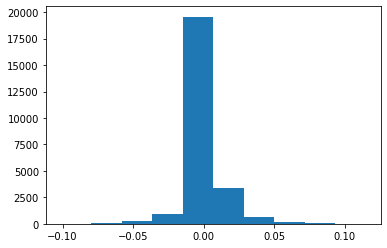

In [7]:
plt.hist(diffs)
plt.show()

In [9]:
np.array(diffs).tofile("../data/softmax-diff-albert-quantized.npz")